2025-03-13 02:37:39.389985: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 02:37:39.996743: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 02:37:39.999078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 02:37:41.813000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 1680 images belonging to 21 classes.
Found 420 images belonging to 21 classes.
Training with Adam optimizer...
Epoch 1/40


2025-03-13 02:37:47.761871: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-03-13 02:37:50.569716: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 1/52 [..............................] - ETA: 4:36 - loss: 3.0426 - accuracy: 0.0625

2025-03-13 02:37:51.299571: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-03-13 02:37:53.926404: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 2/52 [>.............................] - ETA: 2:47 - loss: 6.3697 - accuracy: 0.0625

2025-03-13 02:37:54.658781: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


52/52 [==============================] - 187s 4s/step - loss: 3.2482 - accuracy: 0.0558 - val_loss: 2.9117 - val_accuracy: 0.0938
Epoch 2/40
52/52 [==============================] - 187s 4s/step - loss: 2.8375 - accuracy: 0.1153 - val_loss: 2.6676 - val_accuracy: 0.1995
Epoch 3/40
52/52 [==============================] - 188s 4s/step - loss: 2.6131 - accuracy: 0.1887 - val_loss: 2.3996 - val_accuracy: 0.2716
Epoch 4/40
52/52 [==============================] - 187s 4s/step - loss: 2.3407 - accuracy: 0.2609 - val_loss: 2.3657 - val_accuracy: 0.2692
Epoch 5/40
52/52 [==============================] - 186s 4s/step - loss: 2.1236 - accuracy: 0.3246 - val_loss: 2.2399 - val_accuracy: 0.3149
Epoch 6/40
52/52 [==============================] - 186s 4s/step - loss: 2.0818 - accuracy: 0.3386 - val_loss: 2.2752 - val_accuracy: 0.2788
Epoch 7/40
52/52 [==============================] - 184s 4s/step - loss: 1.8927 - accuracy: 0.3799 - val_loss: 2.2187 - val_accuracy: 0.3197
Epoch 8/40
52/52 [======

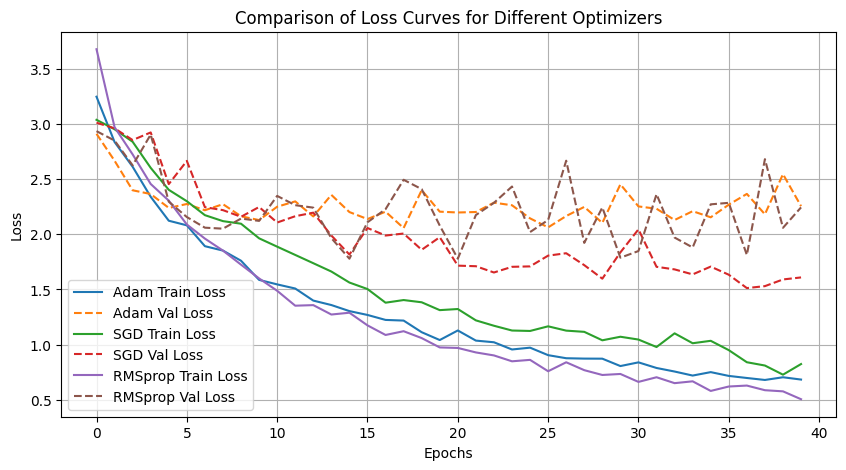

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Configuration
DATA_PATH = 'data'
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_EPOCHS = 40  # Reduce epochs for faster comparison
NUM_CLASSES = 21

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    DATA_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Function to build CNN
def build_cnn(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# Different optimizers
optimizers_list = {
    'Adam': optimizers.Adam(learning_rate=1e-3),
    'SGD': optimizers.SGD(learning_rate=1e-2, momentum=0.9),
    'RMSprop': optimizers.RMSprop(learning_rate=1e-3)
}

history_dict = {}

for opt_name, opt in optimizers_list.items():
    print(f"Training with {opt_name} optimizer...")
    
    model = build_cnn(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=val_generator.samples // BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose=1
    )
    
    history_dict[opt_name] = history.history

# Plot Loss Curves
plt.figure(figsize=(10, 5))
for opt_name, history in history_dict.items():
    plt.plot(history['loss'], label=f'{opt_name} Train Loss')
    plt.plot(history['val_loss'], label=f'{opt_name} Val Loss', linestyle='dashed')

plt.title('Comparison of Loss Curves for Different Optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
